# Starter Notebook

With some code from
_https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train_

# Utilities

Utilities for data loading, etc.

In [4]:
%matplotlib inline

import albumentations as A
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torchvision

from albumentations import OneOf
from albumentations.pytorch.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
base_path = os.path.join('..', 'data')
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

In [6]:
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
train_df

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


In [7]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1
bboxes = train_df['bbox'].copy().apply(lambda x: eval(x))
train_df[['x', 'y', 'w', 'h']] = np.stack(bboxes).astype(int)
train_df

,image_id,width,height,bbox,source,x,y,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834,222,56,36
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226,548,130,58
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377,504,74,160
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834,95,109,107
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26,144,124,117
...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,64,619,84,95
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,292,549,107,82
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,134,228,141,71
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,430,13,184,79


In [8]:
image_ids = train_df['image_id'].unique()
print(f'number of image_ids: {len(image_ids)}')
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

number of image_ids: 3373


# Show Example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


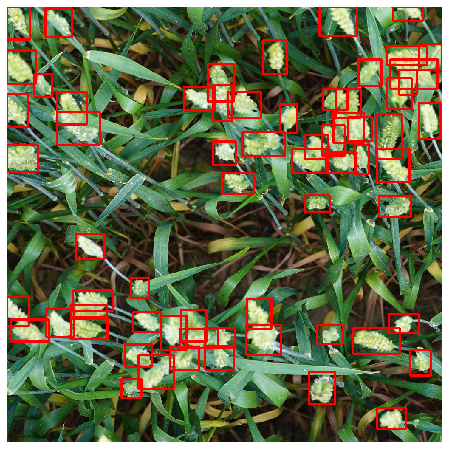

In [6]:
image_id = 'c14c1e300'
image = cv2.imread(os.path.join(train_path, f'{image_id}.jpg'), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

bboxes = train_df[train_df.image_id == image_id][['x', 'y', 'w', 'h']]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for index, row in bboxes.iterrows():
    cv2.rectangle(image, 
                  (row['x'], row['y']), 
                  (row['x'] + row['w'], row['y'] + row['h']), 
                  (220, 0, 0,), 3)

ax.set_axis_off()
ax.imshow(image)

plt.show()

In [7]:
class WheatDataset(Dataset):
    # taken from  https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [8]:
# Albumentations
def get_train_transform():
    return A.Compose([
#         A.Rotate(limit=89, p=1.0),
        A.Flip(0.5),
#         OneOf([
#             A.RandomBrightnessContrast(),
#             A.HueSaturationValue()
#         ]),
        A.RandomBrightnessContrast(),
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Basic Model Setup

In [9]:
num_classes = 2  # 1 class (wheat) + background

model_name = 'faster_rcnn'
# model_name = 'mask_rcnn'
if model_name == 'faster_rcnn':
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    weights_model_name = 'fasterrcnn'
elif model_name == 'mask_rcnn':
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    dim_reduced = 2
    
    model.roi_heads.box_predictor = MaskRCNNPredictor(in_features, dim_reduced, num_classes)
    weights_model_name = 'maskrcnn'
else:
    raise ValueError('Not a valid model name')

In [10]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
train_dataset = WheatDataset(train_df, train_path, get_train_transform())
valid_dataset = WheatDataset(valid_df, train_path, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

# Train the Model

In [13]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 5

In [14]:
# https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/7
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [15]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
                
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if math.isnan(loss_value):
            plot_grad_flow(model.named_parameters())
            raise ValueError('Loss is nan')
        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

C:\Users\Alan\Anaconda3\envs\wheat-detection\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Iteration #50 loss: 0.5811011791229248
Iteration #100 loss: 0.724571704864502
Iteration #150 loss: 0.8035695552825928
Iteration #200 loss: 0.8089777231216431
Iteration #250 loss: 0.7660590410232544
Iteration #300 loss: 0.7064261436462402
Iteration #350 loss: 0.47180071473121643
Iteration #400 loss: 0.5269925594329834
Iteration #450 loss: 0.5982697010040283
Iteration #500 loss: 0.5899050831794739
Iteration #550 loss: 1.0721917152404785
Iteration #600 loss: 0.5740182995796204
Iteration #650 loss: 0.6679651737213135
Epoch #0 loss: 0.7240615874925075
Iteration #700 loss: 0.6845042109489441
Iteration #750 loss: 0.7403196096420288
Iteration #800 loss: 0.6209306716918945
Iteration #850 loss: 1.145740270614624
Iteration #900 loss: 0.7468633651733398
Iteration #950 loss: 0.693938672542572
Iteration #1000 loss: 0.5606248378753662
Iteration #1050 loss: 0.6221309900283813
Iteration #1100 loss: 0.5965040922164917
Iteration #1150 loss: 0.640682578086853
Iteration #1200 loss: 0.5129217505455017
Itera

In [ ]:
plot_grad_flow(model.named_parameters())

In [16]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [17]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


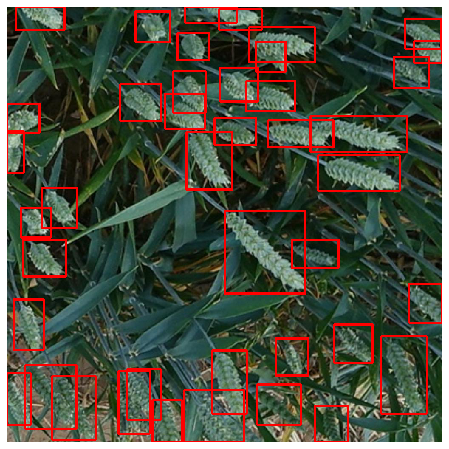

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [19]:
weights_file = f'{weights_model_name}_resnet50_fpn_{num_epochs}epochs.pth'
torch.save(model.state_dict(), weights_file)

# Validation

In [ ]:
weights_file = f'{weights_model_name}_resnet50_fpn_{num_epochs}epochs.pth'
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
# test_df = pd.read_csv(os.path.join(base_path, 'validation.csv'))

# Testing

In [20]:
weights_file = f'{weights_model_name}_resnet50_fpn_{num_epochs}epochs.pth'

In [21]:
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensor()
    ])

In [22]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
test_df = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

In [23]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(weights_file))
model.eval()

x = model.to(device)

In [24]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [25]:
test_dataset = WheatTestDataset(test_df, test_path, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [26]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [27]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

In [28]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9955 554 529 126 197 0.9928 587 776 102 122 ...
1,51f1be19e,0.9933 274 472 141 127 0.9918 605 81 165 186 0...
2,f5a1f0358,0.9889 550 402 79 98 0.9862 151 244 81 94 0.98...
3,796707dd7,0.9760 897 331 107 92 0.9479 1 451 68 77 0.945...
4,51b3e36ab,0.9969 869 288 155 142 0.9969 533 28 259 142 0...


In [29]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


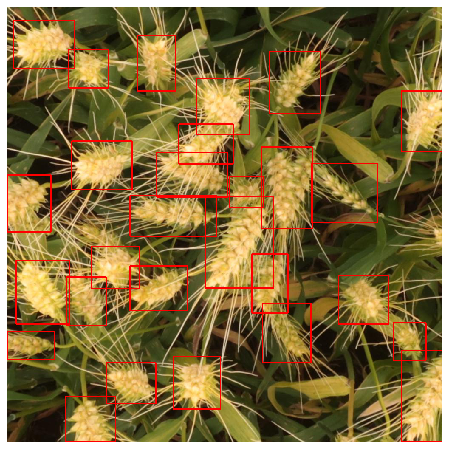

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [31]:
test_df.to_csv('submission.csv', index=False)